# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [1]:
n_samples = 10000

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None, frontier=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    if frontier is not None:
        best = frontier.iloc[frontier['sharpe'].idxmax()]
        plt.scatter(frontier['volatility'], frontier['return'], color='blue', marker='.', s=300)
        plt.scatter(best['volatility'], best['return'], color='red', marker='*', s=300)

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo")
    plt.show()

In [3]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

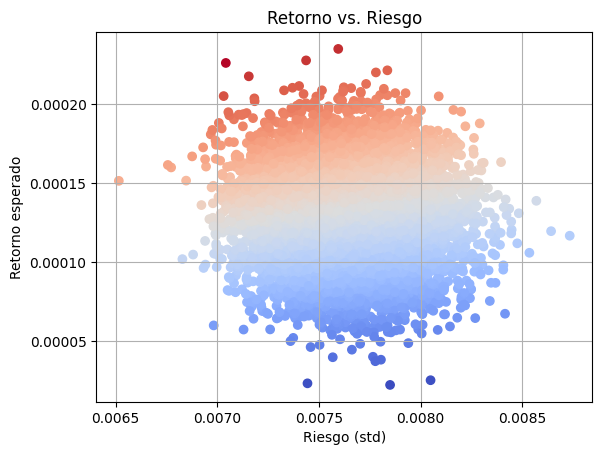

In [4]:

returns = get_data(csv=True)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'asset40', 'asset34', 'asset22', 'asset21', 'asset41', 'asset14', 'asset20', 'asset27', 'asset2', 'asset15'}
[39, 33, 21, 20, 40, 13, 19, 26, 1, 14]


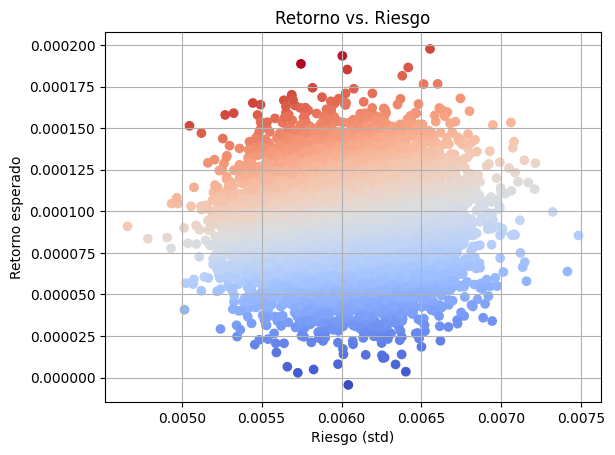

In [5]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 5):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.9) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



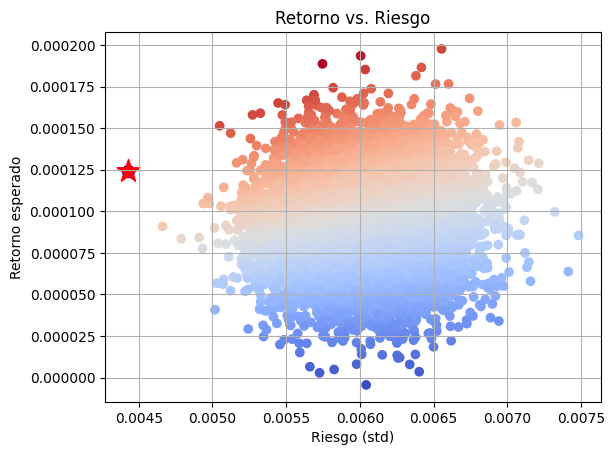

In [6]:
import cvxpy as cp

# 2% se refiere a anual
fixed_income_return = 0.02 / 252

# Los assets con correlacion inferior al 80% y curtosis <= 5 + renta fija
n_assets = len(returns.iloc[0]) + 1

# Retornos esperados
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, fixed_income_return)

# Matriz de covarianza
returns_cov = np.zeros((n_assets, n_assets))
returns_cov[:-1, :-1] = returns.cov().values

# CVXPY

w = cp.Variable(n_assets)
risk = cp.quad_form(w, returns_cov)

constraints = [
    w >= 0, # solo largos
    w[-1] <= 0.1, # renta fija max 10%
    w[:-1] <= 0.1,# Max un 10% en los activos
    cp.sum(w) == 1, # todo el dinero invertido
    w[drop_indexes] == 0, # No invertimos en los que hemos descartado antes
]

problem = cp.Problem(cp.Minimize(risk), constraints)
problem.solve(solver=cp.SCS)

weights = w.value
daily_return = returns_means @ weights
daily_volatility = np.sqrt(weights @ returns_cov @ weights.T)

sharpe = (daily_return - fixed_income_return) / daily_volatility

plot_sharpe(returns, mask, pd.DataFrame([[daily_return, daily_volatility, sharpe]], columns=['return', 'volatility', 'sharpe']))


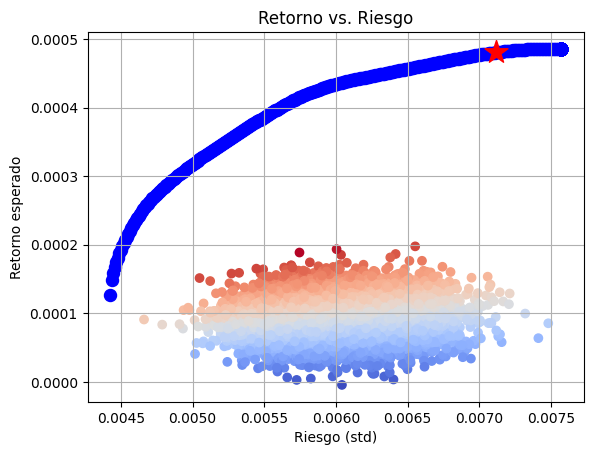

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
149,0.000434,0.005999,0.059159,1.984618e-08,3.294610e-14,1.675291e-07,0.099999,6.056336e-07,0.1,1.502210e-08,...,0.100000,3.057107e-08,1.431263e-02,4.277719e-08,0.035289,2.274226e-08,2.681724e-08,2.182530e-08,5.443867e-08,0.100000
148,0.000434,0.005989,0.059158,1.220816e-07,1.131388e-13,1.022911e-06,0.099977,4.641256e-06,0.1,9.235224e-08,...,0.099998,1.894165e-07,1.339021e-02,2.750681e-07,0.037261,1.389804e-07,1.646729e-07,1.378230e-07,3.471185e-07,0.099999
150,0.000435,0.006010,0.059156,9.580378e-09,1.127946e-14,8.481778e-08,0.099998,1.321965e-07,0.1,7.458252e-09,...,0.100000,1.401363e-08,1.526885e-02,1.829498e-08,0.033250,1.111703e-08,1.300445e-08,9.663129e-09,2.000087e-08,0.100000
147,0.000433,0.005978,0.059154,3.657520e-08,1.261843e-13,3.042981e-07,0.099995,1.854289e-06,0.1,2.757932e-08,...,0.099999,5.726430e-08,1.246524e-02,8.608528e-08,0.040470,4.141470e-08,4.926085e-08,4.235161e-08,1.093221e-07,0.100000
151,0.000435,0.006021,0.059149,8.161731e-08,2.876969e-14,7.082677e-07,0.099997,2.049466e-06,0.1,6.287389e-08,...,0.099999,1.228026e-07,1.594513e-02,1.700257e-07,0.030425,9.430905e-08,1.108572e-07,8.708252e-08,2.013006e-07,0.099999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.000175,0.004466,0.021379,9.214980e-09,4.803498e-14,7.815294e-08,0.005022,9.999988e-02,0.1,9.207779e-09,...,0.047301,3.074197e-08,1.600550e-07,9.999997e-02,0.037657,7.247008e-09,1.473900e-08,2.240713e-02,9.999910e-02,0.100000
3,0.000168,0.004456,0.019785,7.696421e-10,4.017336e-15,6.665140e-09,0.005828,9.999999e-02,0.1,7.673693e-10,...,0.045526,2.834747e-09,1.192755e-08,1.000000e-01,0.037983,5.892948e-10,1.250289e-09,2.553948e-02,9.999998e-02,0.100000
2,0.000159,0.004445,0.017907,1.805904e-08,1.756125e-15,1.667554e-07,0.006736,9.999981e-02,0.1,1.797432e-08,...,0.043318,7.127025e-08,3.190010e-07,9.999995e-02,0.038351,1.342911e-08,2.941154e-08,2.920531e-02,9.999982e-02,0.100000
1,0.000148,0.004435,0.015526,1.295393e-08,4.566637e-15,1.197987e-07,0.007988,9.999987e-02,0.1,1.284930e-08,...,0.040716,5.309273e-08,2.208264e-07,9.999997e-02,0.038926,9.531428e-09,2.107203e-08,3.375324e-02,9.999989e-02,0.100000


In [7]:

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
simulations = pd.DataFrame(columns=columns, dtype=float)

imax = np.argmax(returns_means)
for vol in np.linspace(daily_volatility, np.sqrt(returns_cov[imax, imax]), num=500):

    simulated_weights = cp.Variable(n_assets)
    riesgo = cp.quad_form(simulated_weights, returns_cov)
    constraints = [

        simulated_weights >= 0, # solo largos
        simulated_weights[-1] <= 0.1, # renta fija max 10%
        simulated_weights[:-1] <= 0.1,# Max un 10% en los activos
        cp.sum(simulated_weights) == 1, # todo el dinero invertido
        simulated_weights[drop_indexes] == 0, # No invertimos en los que hemos descartado antes
        riesgo <= vol**2, ## Limitamos el riesgo ##
    ]

    simulated_return = cp.Maximize(returns_means.T @ simulated_weights)
    prob = cp.Problem(simulated_return, constraints)
    resultado = prob.solve()

    used_vol = np.sqrt(riesgo.value)
    obtained_return = simulated_return.value
    obtained_sharpe_ratio = (obtained_return - fixed_income_return) / used_vol

    simulations.loc[len(simulations)] = np.concatenate([[obtained_return], [used_vol], [obtained_sharpe_ratio], simulated_weights.value])

simulations = simulations.sort_values(by='sharpe', ascending=False)
plot_sharpe(returns, mask, simulations)
simulations

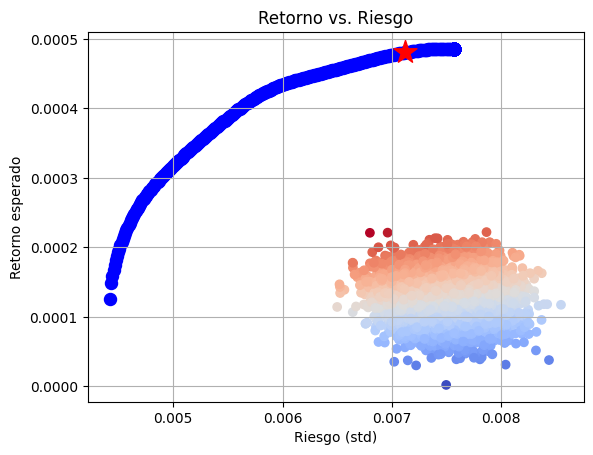

In [8]:
rf_returns_df = returns.copy()
rf_returns_df['RentaFija'] = fixed_income_return
plot_sharpe(rf_returns_df, None, simulations)

In [9]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [10]:
rounded_weights = round_weights(simulations.iloc[0].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(f"Peso en {len(rounded_weights[rounded_weights > 0])} activos")

['0', '0.005', '0.059', '0', '0', '0', '0.099', '0', '0.099', '0', '0.099', '0', '0', '0', '0', '0.099', '0', '0', '0', '0', '0.076', '0', '0', '0', '0', '0.099', '0', '0', '0', '0', '0.021', '0', '0', '0', '0', '0', '0', '0.052', '0.099', '0', '0', '0', '0', '0', '0.099', '0', '0.014', '0', '0.035', '0', '0', '0', '0', '0.099']
Peso en 15 activos


In [11]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.02/252

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 53 is different from 50)

In [ ]:
import numpy as np

# 1. Calcula los retornos diarios de tu cartera
portfolio_daily_returns = returns @ rounded_weights[:-1] + (rounded_weights[-1] * (0.02/252))

# 2. Calcula el valor acumulado de la inversión (empezando desde 1)
wealth_index = (1 + portfolio_daily_returns).cumprod()

# 3. Calcula el pico máximo acumulado en cada momento
previous_peaks = wealth_index.cummax()

# 4. Calcula los drawdowns
drawdowns = (wealth_index - previous_peaks) / previous_peaks

# 5. El Max Drawdown es el valor mínimo (la caída más profunda)
mdd = drawdowns.min()

print(f"Max Drawdown: {mdd * 100:.2f}%")